In [93]:
import pandas as pd



## Setup numeric representation of transitions and values

In [94]:
sentiment_to_numeric = {"negative": 3,  "neutral": 5,  "positive": 9}
# numeric_to_sentiment = {3: "negative",  5: "neutral",  9: "positive"}
numeric_to_echo_transitions = {3: "negative_to_negative",  5: "neutral_to_neutral",  9: "positive_to_positive"}

In [95]:
nr_diffs = []
for ustr in sentiment_to_numeric.keys():
    uval = sentiment_to_numeric[ustr]
    for vstr in sentiment_to_numeric.keys():
        vval = sentiment_to_numeric[vstr]
        if ustr == vstr:
            continue
        nr_diffs.append([uval - vval, uval, vval, ustr, vstr, f"{ustr}_to_{vstr}"])
nr_diffs = pd.DataFrame(nr_diffs, columns=["fdiff", "from", "to", "from_str", "to_str", "transition"])
nr_diffs

,fdiff,from,to,from_str,to_str,transition
0,-2,3,5,negative,neutral,negative_to_neutral
1,-6,3,9,negative,positive,negative_to_positive
2,2,5,3,neutral,negative,neutral_to_negative
3,-4,5,9,neutral,positive,neutral_to_positive
4,6,9,3,positive,negative,positive_to_negative
5,4,9,5,positive,neutral,positive_to_neutral


In [96]:
fdiff_to_transition = nr_diffs.set_index("fdiff")["transition"].to_dict()

## Read data and validate Sentiment values

In [97]:
datadf = pd.read_csv("C:/Users/pog66/Downloads/full_isarel_112top_users.csv", parse_dates=["Date"], usecols=["Date", "Author", "Sentiment"])
datadf.sort_values("Date", inplace=True)
datadf

,Date,Author,Sentiment
35257,2023-10-06 03:24:40,ArtVandelay2021,negative
35256,2023-10-06 04:45:07,Reuters,neutral
35255,2023-10-06 06:21:36,ArtVandelay2021,negative
35254,2023-10-06 07:02:33,realTuckFrumper,neutral
35253,2023-10-06 07:03:03,BrettDGilman,neutral
...,...,...,...
4,2023-10-20 23:57:37,dcexaminer,negative
3,2023-10-20 23:58:06,BaronianConsult,neutral
2,2023-10-20 23:58:21,BaronianConsult,negative
1,2023-10-20 23:58:55,BaronianConsult,neutral


In [98]:
# ignore positive sentiment for now
# datadf.drop(datadf[datadf["Sentiment"] == "positive"].index, inplace=True)

In [99]:
datadf["Sentiment"].unique()

array(['negative', 'neutral', 'positive'], dtype=object)

In [100]:
datadf["NumericSentiment"] = datadf["Sentiment"].apply(lambda x: sentiment_to_numeric[x])
datadf

,Date,Author,Sentiment,NumericSentiment
35257,2023-10-06 03:24:40,ArtVandelay2021,negative,3
35256,2023-10-06 04:45:07,Reuters,neutral,5
35255,2023-10-06 06:21:36,ArtVandelay2021,negative,3
35254,2023-10-06 07:02:33,realTuckFrumper,neutral,5
35253,2023-10-06 07:03:03,BrettDGilman,neutral,5
...,...,...,...,...
4,2023-10-20 23:57:37,dcexaminer,negative,3
3,2023-10-20 23:58:06,BaronianConsult,neutral,5
2,2023-10-20 23:58:21,BaronianConsult,negative,3
1,2023-10-20 23:58:55,BaronianConsult,neutral,5


In [101]:
def gcalc_time(df):
    df["Transitions"] = df["NumericSentiment"].diff()
    df["Trans"] = df[["NumericSentiment", "Transitions"]].apply(lambda row: fdiff_to_transition[row["Transitions"]] if row["Transitions"] in fdiff_to_transition else numeric_to_echo_transitions[row["NumericSentiment"]], axis=1)
    df["timediff"] = df["Date"].diff().apply(lambda x: x.total_seconds())
    rdf = df[["Trans", "timediff"]].groupby("Trans").mean()
    return rdf

In [102]:
time_calcs = datadf[["Author", "NumericSentiment", "Date"]].groupby("Author").apply(lambda gdf: gcalc_time(gdf)).reset_index()
time_calcs

,Author,Trans,timediff
0,2023Jamesthai,negative_to_negative,2525.590909
1,2023Jamesthai,negative_to_neutral,4508.357143
2,2023Jamesthai,neutral_to_negative,5419.168675
3,2023Jamesthai,neutral_to_neutral,1790.338028
4,AHRCUSA,negative_to_negative,5606.565789
...,...,...,...
567,xoxnews,positive_to_neutral,767.000000
568,zerohedge,negative_to_negative,11140.500000
569,zerohedge,negative_to_neutral,18817.222222
570,zerohedge,neutral_to_negative,22204.222222


In [104]:
time_calcs.pivot(index="Author", columns="Trans", values="timediff").fillna(float("inf"))#.to_csv("Sentiment_Transition_Time.csv")

Trans,negative_to_negative,negative_to_neutral,negative_to_positive,neutral_to_negative,neutral_to_neutral,neutral_to_positive,positive_to_negative,positive_to_neutral,positive_to_positive
Author,,,,,,,,,
2023Jamesthai,2.525591e+03,4.508357e+03,inf,5.419169e+03,1790.338028,inf,inf,inf,inf
AHRCUSA,5.606566e+03,4.460328e+03,inf,5.298966e+03,3370.285714,inf,inf,inf,inf
AJEnglish,3.620117e+03,2.899723e+03,inf,3.464947e+03,2444.324176,inf,inf,inf,inf
AP,1.358085e+04,1.304329e+04,inf,1.163645e+04,10527.363636,inf,inf,inf,inf
AndyVermaut,1.889333e+03,1.767694e+03,inf,1.537765e+03,1839.494759,1470.0,inf,88.0,inf
...,...,...,...,...,...,...,...,...,...
ultradeadd,2.053232e+03,4.000779e+03,inf,4.023552e+03,3051.490066,inf,inf,inf,inf
washingtonpost,6.884000e+03,8.048477e+03,inf,6.868533e+03,5330.863636,inf,inf,inf,inf
worldcotrader,inf,inf,inf,inf,65.608696,inf,inf,inf,inf


In [ ]:
time_calcs.pivot(index="Author", columns="Trans", values="timediff").fillna(float("inf")).to_csv("Sentiment_Transition_Time_NO_POSITIVES.csv")

In [9]:
def gcalc(df):
    df["Transitions"] = df["NumericSentiment"].diff()
    df["Trans"] = df[["NumericSentiment", "Transitions"]].apply(lambda row: fdiff_to_transition[row["Transitions"]] if row["Transitions"] in fdiff_to_transition else numeric_to_echo_transitions[row["NumericSentiment"]], axis=1)
    df.dropna(inplace=True)
    return df["Trans"].value_counts() / df.shape[0]

In [10]:
gcalcs = datadf[["Author", "NumericSentiment"]].groupby("Author").apply(lambda gdf: gcalc(gdf))#.reset_index()
gcalcs

Author                             
2023Jamesthai  neutral_to_neutral      0.378667
               negative_to_neutral     0.224000
               neutral_to_negative     0.221333
               negative_to_negative    0.176000
AHRCUSA        negative_to_negative    0.314050
                                         ...   
xoxnews        neutral_to_positive     0.001808
zerohedge      neutral_to_neutral      0.534884
               negative_to_neutral     0.209302
               neutral_to_negative     0.209302
               negative_to_negative    0.046512
Name: Trans, Length: 572, dtype: float64

In [11]:
gcalcs.reset_index().rename(columns={"level_1":"Trans", "Trans": "val"}).pivot(columns="Trans", index="Author", values="val").fillna(0).to_csv("./Sentiment_Transition_Values.csv")

In [14]:
gcalcs.reset_index().rename(columns={"level_1":"Trans", "Trans": "val"}).pivot(columns="Trans", index="Author", values="val").fillna(0).to_csv("./Sentiment_Transition_Values_NO_POSITIVES.csv")

,Author,level_1,Trans
0,2023Jamesthai,neutral_to_neutral,0.378667
1,2023Jamesthai,negative_to_neutral,0.224000
2,2023Jamesthai,neutral_to_negative,0.221333
3,2023Jamesthai,negative_to_negative,0.176000
4,AHRCUSA,negative_to_negative,0.314050
...,...,...,...
434,xoxnews,negative_to_negative,0.197464
435,zerohedge,neutral_to_neutral,0.534884
436,zerohedge,negative_to_neutral,0.209302
437,zerohedge,neutral_to_negative,0.209302


In [115]:
df = pd.read_csv("Sentiment_Transition_Values_NO_POSITIVES.csv")
df

,Author,negative_to_negative,negative_to_neutral,neutral_to_negative,neutral_to_neutral
0,2023Jamesthai,0.176000,0.224000,0.221333,0.378667
1,AHRCUSA,0.314050,0.239669,0.243802,0.202479
2,AJEnglish,0.139535,0.218605,0.218605,0.423256
3,AP,0.419355,0.225806,0.236559,0.118280
4,AndyVermaut,0.022624,0.128205,0.128205,0.720965
...,...,...,...,...,...
106,ultradeadd,0.194366,0.191549,0.188732,0.425352
107,washingtonpost,0.222222,0.257310,0.263158,0.257310
108,worldcotrader,0.000000,0.000000,0.000000,1.000000
109,xoxnews,0.197464,0.231884,0.233696,0.336957


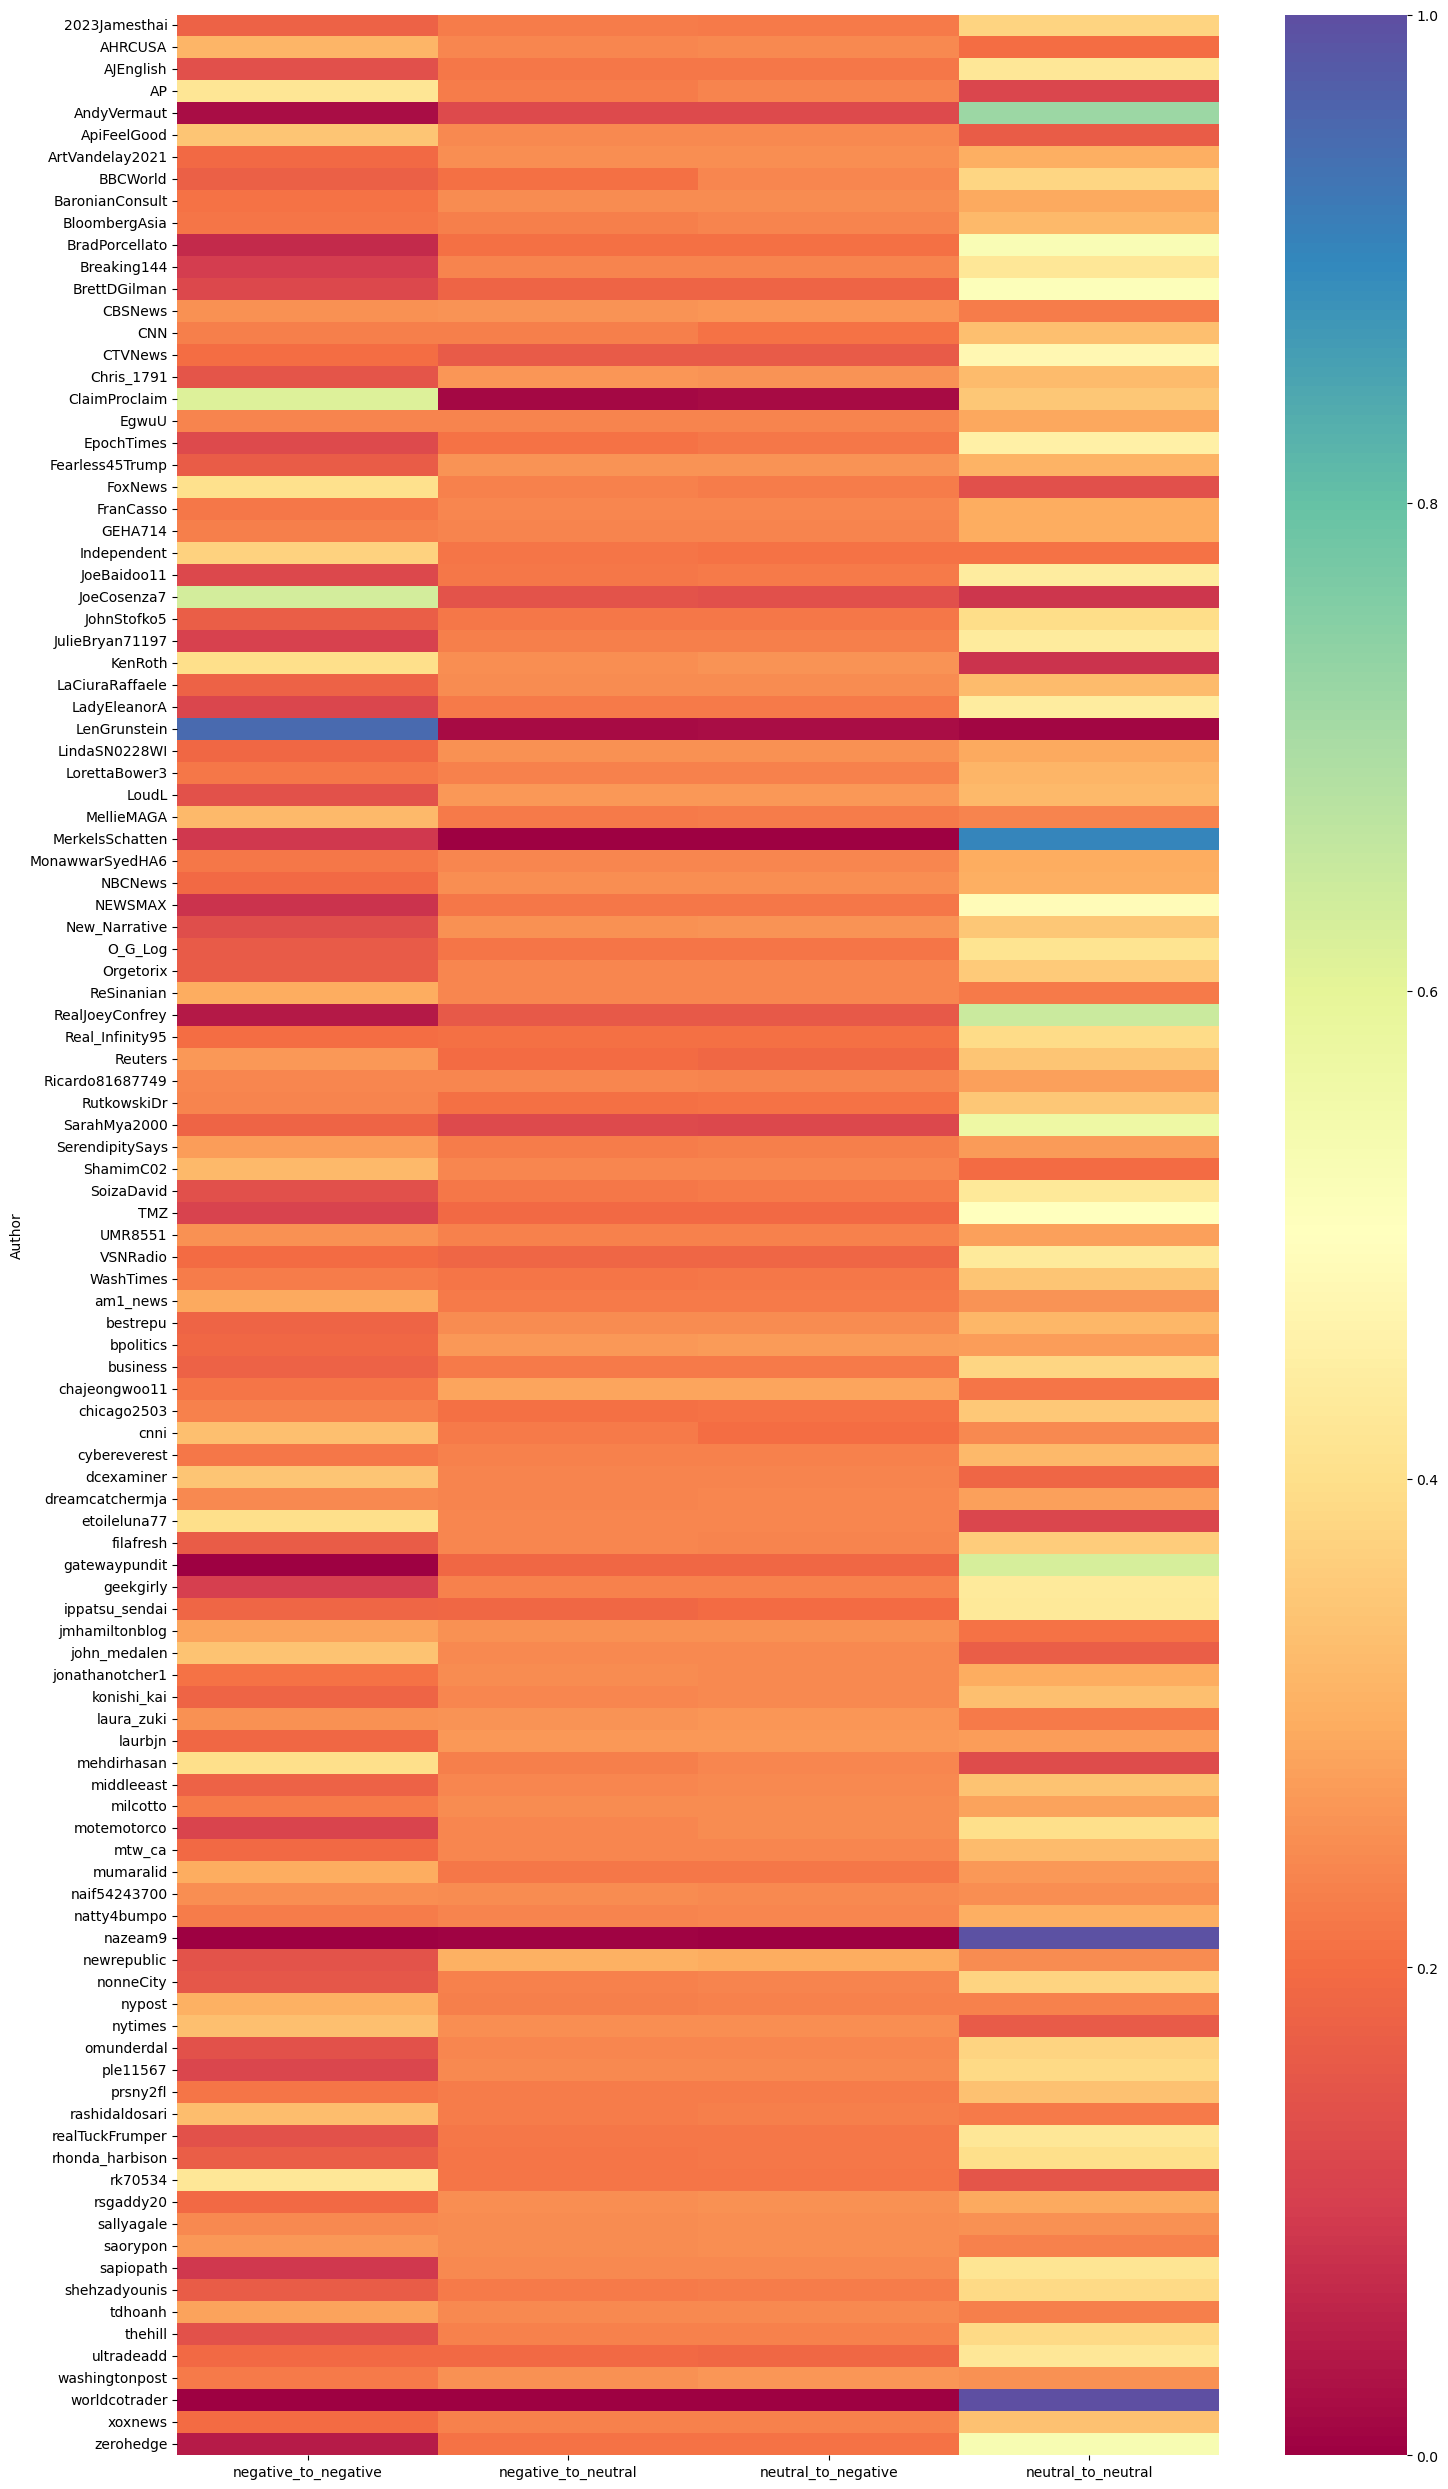

In [134]:
fig, ax = plt.subplots(figsize=(15,25))
sns.heatmap(df.set_index("Author"), cmap=sns.color_palette("Spectral", as_cmap=True))
plt.tight_layout()
plt.savefig("before_marginal_draft.png")
plt.show()